In [40]:
import mne
import os
from mne.preprocessing import ICA
%matplotlib qt5

In [41]:
# LOAD THE DATA
base_path = os.path.join(os.getcwd(), 'data')
print("The base directory is: ", base_path)
eeg_dir = os.path.join(base_path, 'eeg')
print("The files in the folder: ", os.listdir(base_path))

The base directory is:  C:\Users\alisa_000\Neuromarketing\data
The files in the folder:  ['477819.eeg', '477819.vhdr', '477819.vmrk', '477819_1.edf', '477819_2.edf', '477819_2.eeg', '477819_2.vhdr', '477819_2.vmrk', 'averaged_data-ave.fif']


In [11]:
raw = mne.io.read_raw_fif("filtered_raw.fif", preload=True)

Opening raw data file C:\Users\alisa_000\Neuromarketing\filtered_raw.fif...
    Range : 96209 ... 571700 =     96.209 ...   571.700 secs
Ready.
Reading 0 ... 475491  =      0.000 ...   475.491 secs...


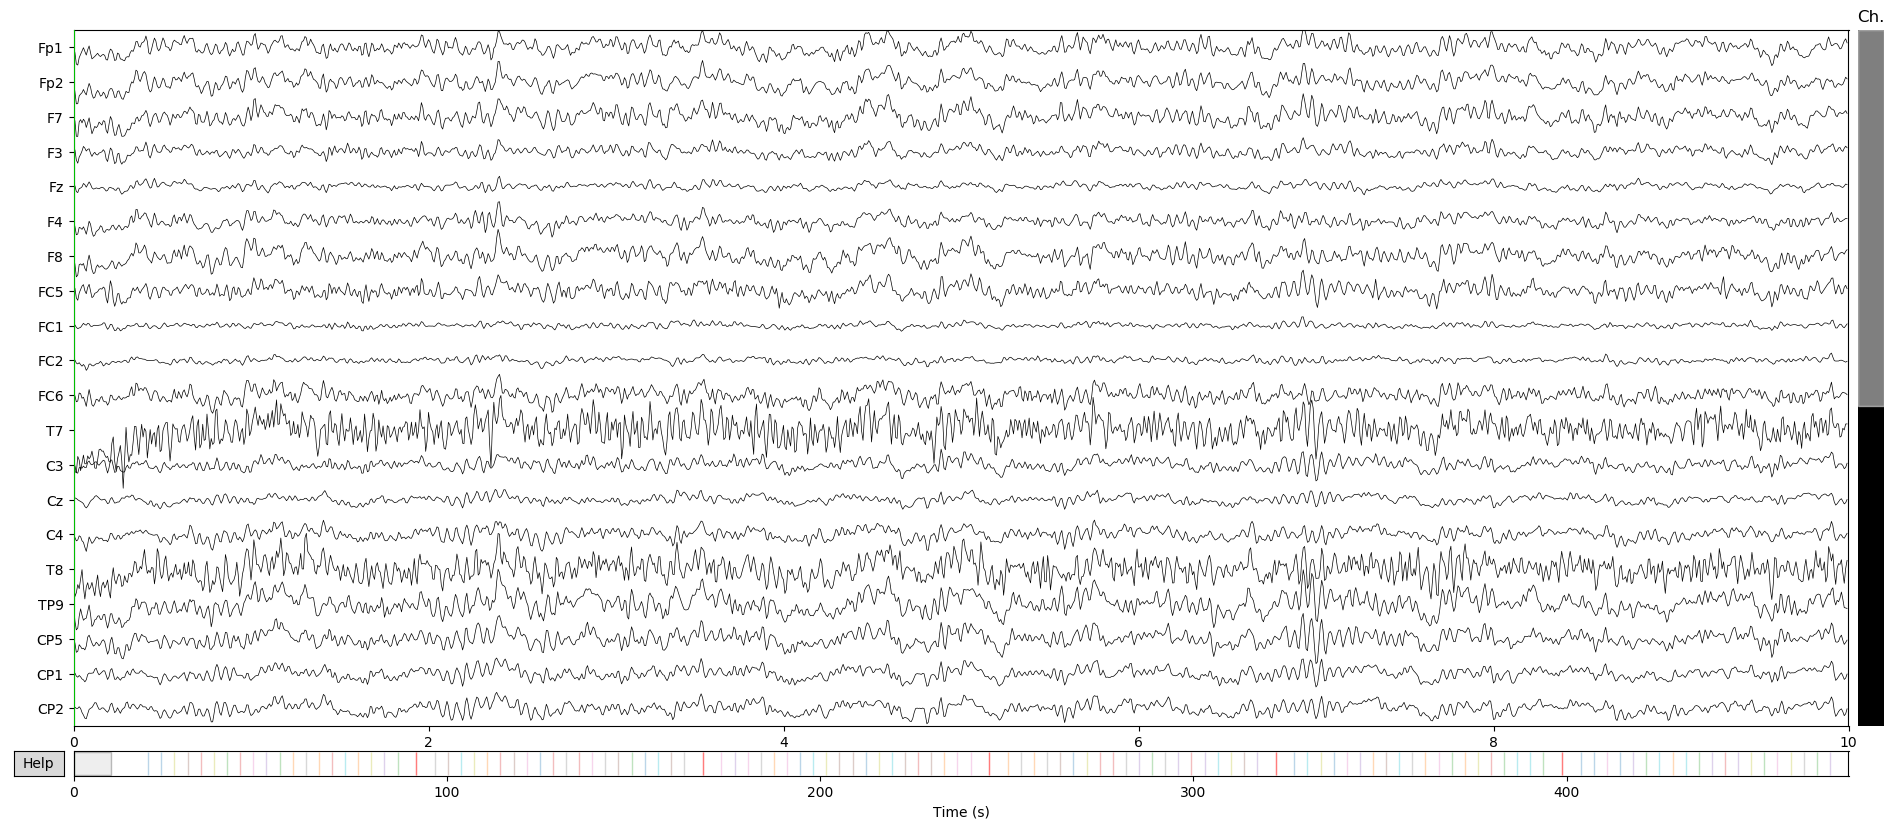

In [12]:
raw.plot()

In [47]:
# FIT ICA

# Set the parameters
n_components = 25
method = 'fastica'
decim = 3 
random_state = 23

# Run the analysis
ica = ICA(n_components=n_components, method=method, random_state=random_state)
reject = None
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)

ica.fit(raw, picks=picks, decim=decim, reject=reject)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 25 components
Fitting ICA took 13.1s.


<ICA  |  raw data decomposition, fit (fastica): 158498 samples, 25 components, channels used: "eeg">

In [48]:
# Plot ICA components
ica.plot_components()

[<Figure size 750x700 with 20 Axes>, <Figure size 750x250 with 5 Axes>]

EOG channel index for this subject is: [32 33 34 35]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (16.384 sec) selected
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (16.384 sec) selected
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (16.384 sec) selected
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (16.384 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 103
103 matching events found
No baseline correction applied
Not setting metadata
Loading data for 103 events and 1001 original time points ...
0 bad epochs dropped
EOG channel index for this subject is: [32 33 34 35]
Filtering the data to remove DC offset to help distinguish blinks from saccades


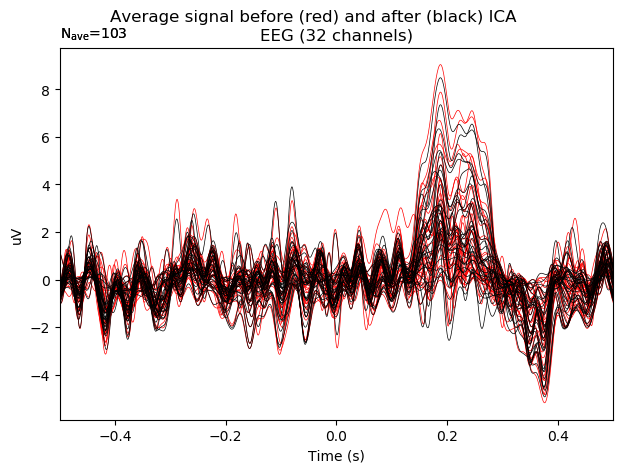

In [30]:
# Advanced

from mne.preprocessing import create_eog_epochs

eog_average = create_eog_epochs(raw, reject=reject, picks=picks).average()
eog_epochs = create_eog_epochs(raw, reject=reject)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs, threshold = 2) # find via correlation

# Plot ICA
ica.plot_scores(scores, exclude=eog_inds)  # look at r scores of components
ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course
ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
#ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    #image_args={'sigma': 1.})
                    
#eog_inds=[0] ## if you spot bad component still, reject them manually 
#ica.exclude.extend(eog_inds)
#del eog_inds, scores, eog_epochs, eog_average

Transforming to ICA space (25 components)
Zeroing out 3 ICA components
Transforming to ICA space (25 components)
Zeroing out 3 ICA components


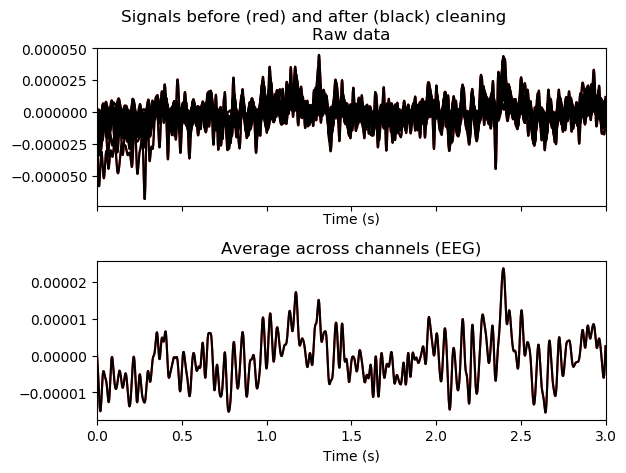

In [33]:
# Compare the clean vs. unclean
ica.apply(raw)
ica.plot_overlay(raw)

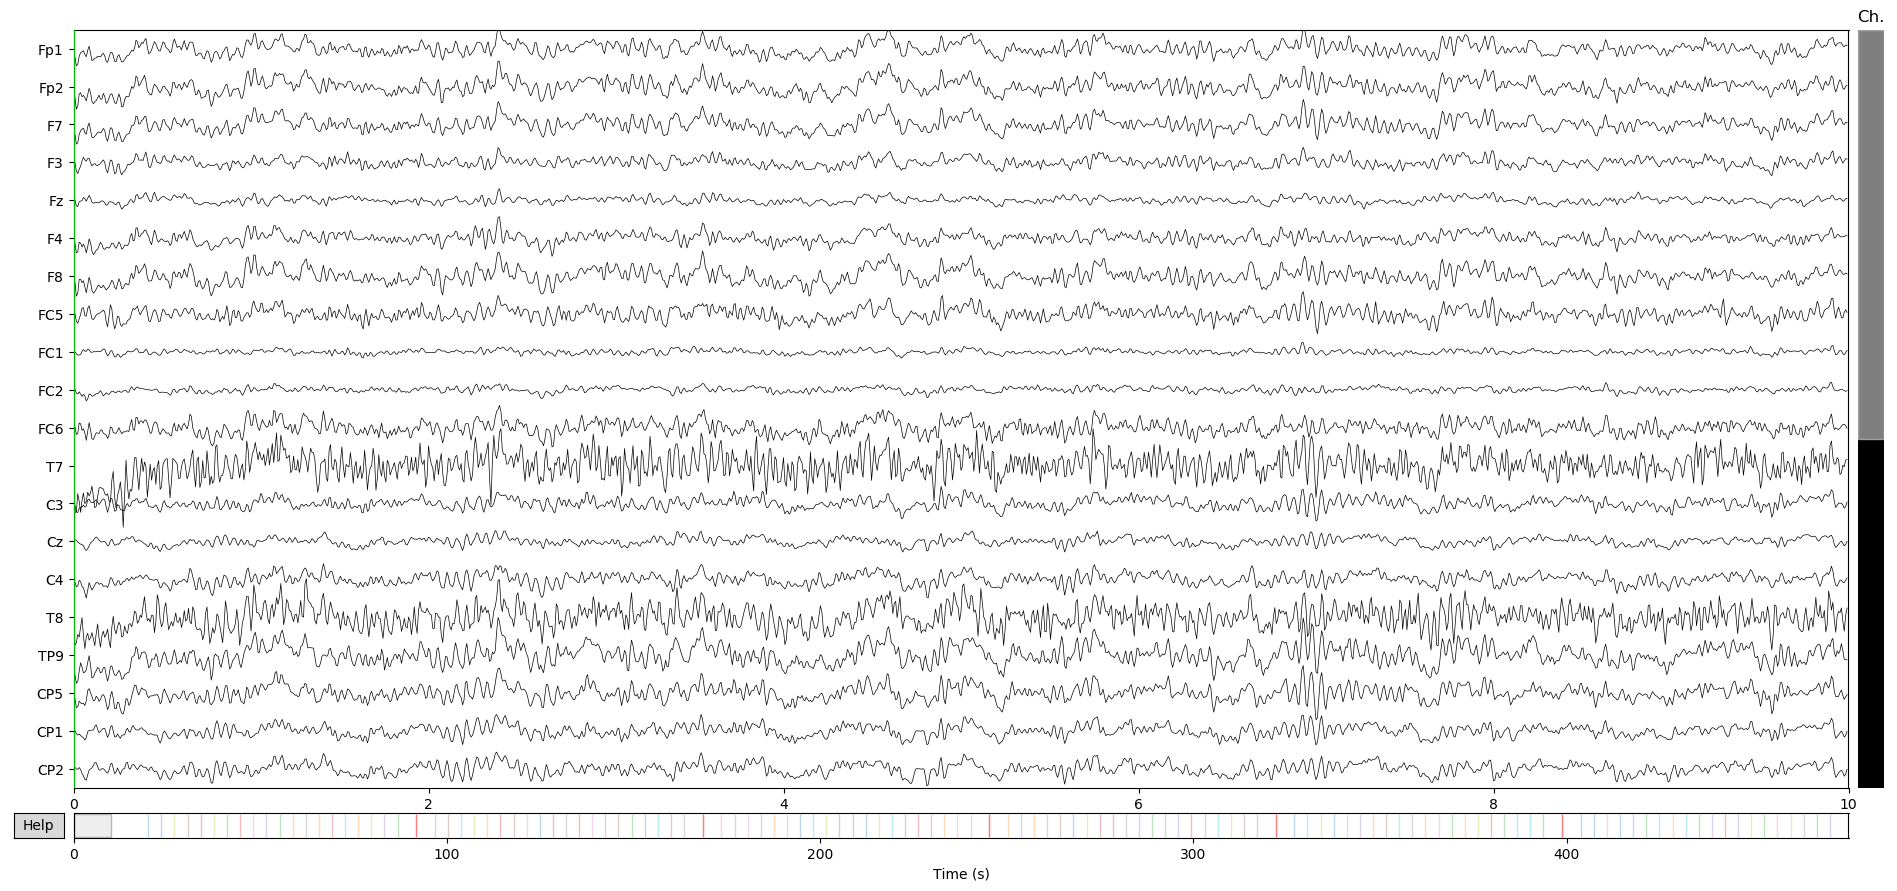

In [26]:
raw.plot()

In [27]:
#raw.save("clean_raw.fif")

Writing C:\Users\alisa_000\Neuromarketing\clean_raw.fif
Closing C:\Users\alisa_000\Neuromarketing\clean_raw.fif [done]


In [42]:
raw = mne.io.read_raw_fif("clean_raw.fif", preload=True)

Opening raw data file C:\Users\alisa_000\Neuromarketing\clean_raw.fif...
    Range : 96209 ... 571700 =     96.209 ...   571.700 secs
Ready.
Reading 0 ... 475491  =      0.000 ...   475.491 secs...


In [43]:
# Set ref.
raw_no_ref, _ = mne.set_eeg_reference(raw, [])

# Set the parameters for constructing epochs
events = mne.find_events(raw, stim_channel = 'STI 014')
event_id = {'FINMAT': 1, 'FINCON': 2,
            'FORMAT': 3, 'FORCON': 4}
tmin, tmax = -0.2, 0.8
#reject = dict(eeg=180e-6, eog=150e-6)
reject = None

# Create more compact stucture
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax,
                     reject=reject)
# Grouping
i = 0
for value in events[:, 2]:
    if value <= 60:
        events[i, 2] = 1
    elif value <= 120:
        events[i, 2] = 2
    elif value <= 180:
        events[i, 2] = 3
    else:
        events[i, 2] = 4
    i += 1
    
# Double check
print(epochs_params)

EEG data marked as already having the desired reference. Preventing automatic future re-referencing to an average reference.
120 events found
Event IDs: [  2   3   4   8  14  15  17  18  19  21  23  28  30  32  33  34  35  36
  37  38  41  42  44  47  48  51  53  54  55  57  62  63  64  68  74  75
  77  78  79  81  83  88  90  92  93  94  95  96  97  98 101 102 104 107
 108 111 113 114 115 117 121 122 132 137 138 139 141 143 144 145 147 148
 150 151 152 155 157 158 160 162 166 168 169 171 172 173 176 177 179 180
 181 182 192 197 198 199 201 203 204 205 207 208 210 211 212 215 217 218
 220 222 226 228 229 231 232 233 236 237 239 240]
{'events': array([[116209,      0,      4],
       [119729,      0,      3],
       [123244,      0,      4],
       [126760,      0,      4],
       [130272,      0,      1],
       [133822,      0,      1],
       [137335,      0,      4],
       [140852,      0,      3],
       [144370,      0,      4],
       [147882,      0,      2],
       [151397,   

In [44]:
epochs = mne.Epochs(raw_no_ref, **epochs_params)

120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [46]:
print(epochs)

finmatc = epochs['FINCON'].average()
finconf = epochs['FINMAT'].average()
formatc = epochs['FORCON'].average()
forconf = epochs['FORMAT'].average()

<Epochs  |   120 events (good & bad), -0.2 - 0.8 sec, baseline [None, 0], ~94 kB, data not loaded,
 'FINCON': 30
 'FINMAT': 30
 'FORCON': 30
 'FORMAT': 30>


In [47]:
all_evokeds = [finmatc, finconf, formatc, forconf]
print(all_evokeds)

[<Evoked  |  'FINCON' (mean, N=30), [-0.2, 0.8] sec, 32 ch, ~336 kB>, <Evoked  |  'FINMAT' (mean, N=30), [-0.2, 0.8] sec, 32 ch, ~336 kB>, <Evoked  |  'FORCON' (mean, N=30), [-0.2, 0.8] sec, 32 ch, ~336 kB>, <Evoked  |  'FORMAT' (mean, N=30), [-0.2, 0.8] sec, 32 ch, ~336 kB>]


In [10]:
# Just a plotting parameter
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))


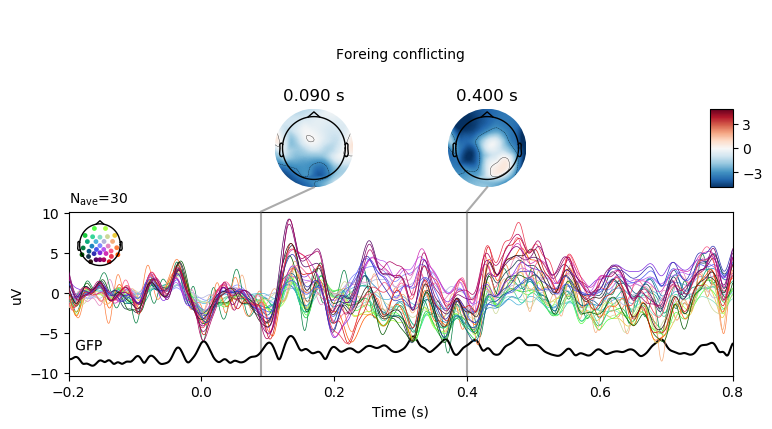

In [11]:
ts_args = dict(gfp=True, time_unit='s')
topomap_args = dict(sensors=False, time_unit='s')

finmatc.plot_joint(title='Finnish matching', times=[.09, .40],
                        ts_args=ts_args, topomap_args=topomap_args)
finconf.plot_joint(title='Finnish conflicting', times=[.09, .40],
                        ts_args=ts_args, topomap_args=topomap_args)
formatc.plot_joint(title='Foreing matching', times=[.09, .40],
                        ts_args=ts_args, topomap_args=topomap_args)
forconf.plot_joint(title='Foreing conflicting', times=[.09, .40],
                        ts_args=ts_args, topomap_args=topomap_args)

No picks, plotting the GFP ...


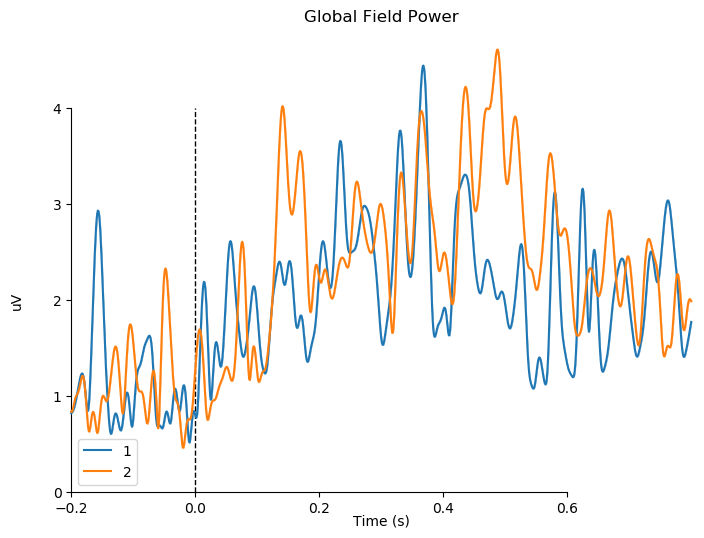

In [12]:
mne.viz.plot_compare_evokeds(all_evokeds[0:2])

#[finmatc, finconf, formatc, forconf]

No picks, plotting the GFP ...


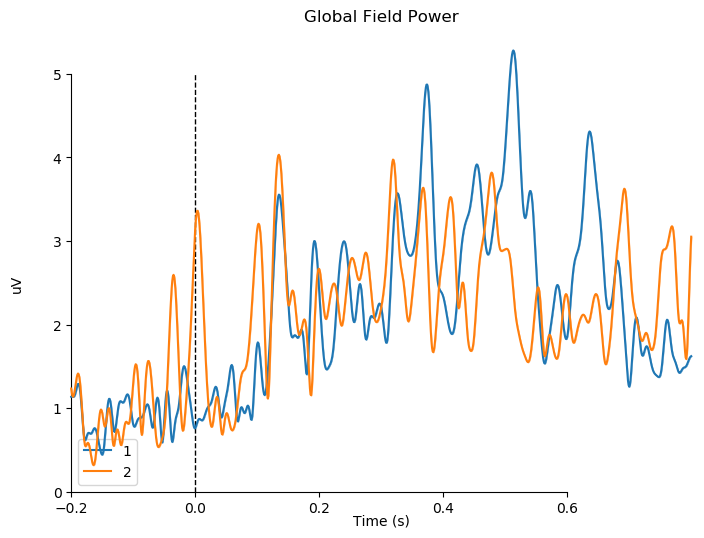

In [23]:
mne.viz.plot_compare_evokeds(all_evokeds[2:4])

In [48]:
#spacial filter

import numpy as np

In [39]:
# Statistical testing


#print(all_evokeds[0].data[0, :])
#print(all_evokeds[2].data[0, :])

cross_correlations_channels = []

for i in range(32):
    cc = np.correlate(all_evokeds[0].data[i, :], all_evokeds[2].data[i, :], mode="valid")
    cross_correlations_channels.append(float(cc))
    

print(cross_correlations_channels)

[4.188708233812014e-09, 2.2341185095517205e-09, 3.2244412654033447e-09, 2.6206992178009127e-09, 1.7412550399697703e-09, 1.4259422250035761e-09, 2.25285649351543e-09, 1.6145885321500277e-09, 5.917055412849719e-10, 6.52802751138886e-11, 4.190805675018333e-12, 2.5912713694247505e-09, 9.447867033245828e-10, 4.881260549874252e-10, 7.153227796348764e-10, 2.0532867840752784e-09, 4.336559992997905e-09, 2.3460025743189743e-09, 6.066143028050155e-10, 1.5500201236994037e-09, 1.8375417825344553e-09, 5.374070243765407e-09, 3.836276498536559e-09, 2.0021782735939266e-09, 1.7041450034636852e-09, 4.209985955725398e-09, 6.138953229979549e-09, 5.28697956591851e-09, 6.683958295441158e-09, 5.346256207052671e-09, 6.909582980541673e-09, 5.937464995323291e-09]


In [44]:
# DIMENSION REDUCTION
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
pca.fit(all_evokeds[0].data)

print(pca.explained_variance_ratio_)


[0.37029218]


In [51]:
finmatc.gfp()

AttributeError: 'EvokedArray' object has no attribute 'gfp'

In [7]:
### JUHO ###

# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [8]:
import numpy as np
# set epoching parameters LAITA EVENT ID kohdalle 1, 2, 3 tai 4. Riippuen minkä tapauksen haluut.
event_id, tmin, tmax = 1, -0.2, 0.8
baseline = None

# get the header to extract events
raw = mne.io.read_raw_fif("clean_raw.fif", preload=False)
#events = mne.find_events(raw, stim_channel='STI 014')
events=events

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne.io.read_raw_fif("clean_raw.fif", preload=True)
    raw.pick_types(eeg=True, eog=False)  # we just look at gradiometers

    # bandpass filter and compute Hilbert
    raw.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1,  # in each band and skip "auto" option.
               fir_design='firwin')
    raw.apply_hilbert(n_jobs=1, envelope=False)

    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)
    # remove evoked response and get analytic signal (envelope)
    epochs.subtract_evoked()  # for this we need to construct new epochs.
    epochs = mne.EpochsArray(
        data=np.abs(epochs.get_data()), info=epochs.info, tmin=epochs.tmin)
    # now average and move on
    frequency_map.append(((band, fmin, fmax), epochs.average()))

Opening raw data file C:\Users\alisa_000\Neuromarketing\clean_raw.fif...
    Range : 96209 ... 571700 =     96.209 ...   571.700 secs
Ready.
Opening raw data file C:\Users\alisa_000\Neuromarketing\clean_raw.fif...
    Range : 96209 ... 571700 =     96.209 ...   571.700 secs
Ready.
Reading 0 ... 475491  =      0.000 ...   475.491 secs...
Setting up band-pass filter from 4 - 7 Hz
Filter length of 3301 samples (3.301 sec) selected
Setting up band-pass filter from 4 - 7 Hz
Filter length of 3301 samples (3.301 sec) selected
Setting up band-pass filter from 4 - 7 Hz
Filter length of 3301 samples (3.301 sec) selected
Setting up band-pass filter from 4 - 7 Hz
Filter length of 3301 samples (3.301 sec) selected
Setting up band-pass filter from 4 - 7 Hz
Filter length of 3301 samples (3.301 sec) selected
Setting up band-pass filter from 4 - 7 Hz
Filter length of 3301 samples (3.301 sec) selected
30 matching events found
No baseline correction applied
Not setting metadata
0 projection items activat

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


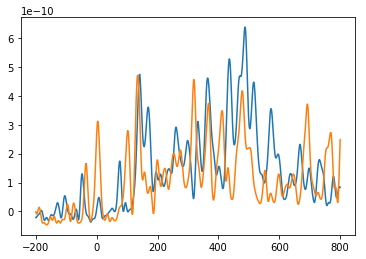

In [89]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.utils import resample
## The statistical analysis ###
# WRITTEN: Ali Salloum 4.5.2019

# We compare the Global field power distributions between FINMATCH and FORMATCH. 

FCON = all_evokeds[0]
FMAT = all_evokeds[1]
ECON = all_evokeds[2]
EMAT = all_evokeds[3]

# Preparing stuff
FMAT_gfp = np.sum(FMAT.data ** 2, axis=0)
FMAT_gfp = mne.baseline.rescale(FMAT_gfp, FMAT.times * 1e3, baseline=(None, 0))
EMAT_gfp = np.sum(EMAT.data ** 2, axis=0)
EMAT_gfp = mne.baseline.rescale(EMAT_gfp, EMAT.times * 1e3, baseline=(None, 0))

# Crosscorrelation between two signals, should be very low
cc = np.correlate(FMAT_gfp, EMAT_gfp, mode="valid")
# Perform the Kolmogorov-Smirnov test for goodness of fit, skip this now

plt.plot(FMAT.times * 1e3, FMAT_gfp)
plt.plot(EMAT.times * 1e3, EMAT_gfp)

plt.show()

(array([1.600e+01, 1.730e+02, 9.560e+02, 2.541e+03, 3.284e+03, 2.164e+03,
        7.220e+02, 1.310e+02, 1.200e+01, 1.000e+00]),
 array([9.68308044e-11, 9.99123433e-11, 1.02993882e-10, 1.06075421e-10,
        1.09156960e-10, 1.12238499e-10, 1.15320038e-10, 1.18401577e-10,
        1.21483115e-10, 1.24564654e-10, 1.27646193e-10]),
 <a list of 10 Patch objects>)

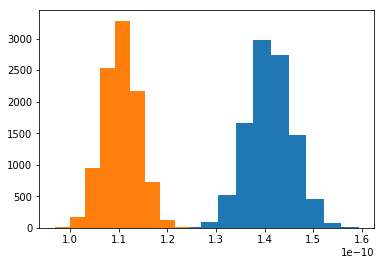

In [91]:
# Peforming the bootstrapping, I spoke about this method in our last meeting

FMAT_gfp_bootstrap = []
for i in range(10000):
    np.random.seed(i)
    FMAT_gfp_bootstrap.append((resample(FMAT_gfp)))

FMAT_gfp_bootstrap = np.mean(FMAT_gfp_bootstrap, axis=1)
plt.hist(FMAT_gfp_bootstrap)

EMAT_gfp_bootstrap = []
for i in range(10000):
    np.random.seed(i)
    EMAT_gfp_bootstrap.append((resample(EMAT_gfp)))

EMAT_gfp_bootstrap = np.mean(EMAT_gfp_bootstrap, axis=1)
plt.hist(EMAT_gfp_bootstrap)

H0:μ1−μ0=0
Ha:μ1−μ0>0

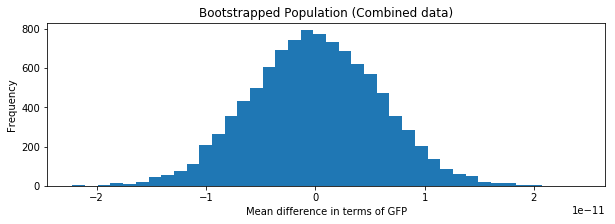

In [97]:
combined = np.concatenate((FMAT_gfp, EMAT_gfp), axis=0)

perms_FMAT = []
perms_EMAT = []

for i in range(10000):
    np.random.seed(i)
    perms_FMAT.append(resample(combined, n_samples = len(FMAT_gfp)))
    perms_EMAT.append(resample(combined, n_samples = len(EMAT_gfp)))
    
dif_bootstrap_means = (np.mean(perms_FMAT, axis=1)-np.mean(perms_EMAT, axis=1))

fig = plt.figure(figsize=(10,3))
ax = plt.hist(dif_bootstrap_means, bins=40)

plt.xlabel('Mean difference in terms of GFP')
plt.ylabel('Frequency')
plt.title('Bootstrapped Population (Combined data)')
plt.show()

In [98]:
obs_difs = (np.mean(FMAT_gfp) - np.mean(EMAT_gfp))
print('observed difference in means: {}'.format(obs_difs))

p_value = dif_bootstrap_means[dif_bootstrap_means >= obs_difs].shape[0]/10000
print('p-value: {}'.format(p_value))

observed difference in means: 3.068772992456916e-11
p-value: 0.0


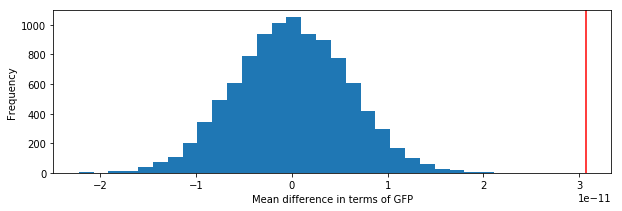

In [100]:
fig = plt.figure(figsize=(10,3))
ax = plt.hist(dif_bootstrap_means, bins=30)

plt.xlabel('Mean difference in terms of GFP')
plt.ylabel('Frequency')
plt.axvline(obs_difs, color='r')
plt.show()

In [22]:
import matplotlib.pyplot as plt
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-200, 800)
    #ax.set_title("Finnish matching")
    #ax.set_title("Finnish conflicting")
    #ax.set_title("Foreign matching")
    ax.set_title("Foreign conflicting")

axes.ravel()[-1].set_xlabel('Time [ms]')

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5,0,'Time [ms]')

In [ ]:
import matplotlib.pyplot as plt
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-200, 800)
    #ax.set_title("Finnish matching")
    #ax.set_title("Finnish conflicting")
    #ax.set_title("Foreign matching")
    ax.set_title("Foreign conflicting")

axes.ravel()[-1].set_xlabel('Time [ms]')